In [2]:
!~/new_python_3_11_env/bin/python3 -m pip install tensorflow-datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 59.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 41.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 62.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.7/221.7 kB 8.6 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21483 sha256=ed36673593f7058df1190b258aef1595ea0d937150af0243bdf3997fe78150d1
  Stored in directory: /home/jovyan/.cache/pip/wheels/90/74/b1/9b54c896b8d9409e9268329d4d45ede8a8040abe91c8879932
Successfully built promise

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: /ho

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [71]:
# Load original model
original_model = tf.keras.models.load_model('dej_cnn_mnist_model.keras')  # Replace with your model file
original_model.trainable = False  # Freeze weights


In [72]:
# @ layers with 2 deconvolution layers
def build_atn(input_shape):
    model = tf.keras.Sequential([
        # First convolutional layers to capture features
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),  # Downsample (14, 14, 64)

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample (7, 7, 128)

        # Fully connected layer to integrate features
        layers.Flatten(),  # Flatten to shape (7 * 7 * 128 = 6272)
        layers.Dense(6272, activation='relu'),  # Match the reshape target

        # Deconvolution layers to reconstruct adversarial examples
        layers.Reshape((7, 7, 128)),  # Reshape for deconvolution
        layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same'),  # (14, 14, 128)
        layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same'),  # (28, 28, 64)
        
        layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),  # Output layer (28, 28, 1)
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model

# Build the ATN
input_shape = (28, 28, 1)  # MNIST dataset shape
atn = build_atn(input_shape)


In [ ]:
# Define ATN 2 Layers only convulution
def build_atn(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(np.prod(input_shape), activation='sigmoid'),  # Use sigmoid for range [0, 1]
        layers.Reshape(input_shape),
        layers.Lambda(lambda x: x * 255)  # Scale to [0, 255]
    ])
    return model


input_shape = (28, 28, 1)  # Assuming MNIST dataset
atn = build_atn(input_shape)


In [73]:
# Define input loss and output loss function
def input_loss(x, x_prime):
    return tf.reduce_mean(tf.square(tf.cast(x, tf.float32) - x_prime))  # Cast x to float32  # L2 loss

def output_loss(y_pred, y_target):
    return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_target, y_pred)) # crossentropy



In [74]:
# Combine the models
input_img = tf.keras.Input(shape=input_shape)
x_prime = atn(input_img)
y_pred = original_model(x_prime)

combined_model = tf.keras.Model(inputs=input_img, outputs=[x_prime, y_pred])


In [75]:
def get_second_highest_target(y_pred_original):
    # Sort predictions to find the highest and second-highest indices
    top_2_indices = tf.argsort(y_pred_original, direction='DESCENDING', axis=1)[:, :2]
    second_highest_indices = top_2_indices[:, 1]

    # Create one-hot encoding for the second-highest class
    y_target = tf.one_hot(second_highest_indices, depth=y_pred_original.shape[1])
    return y_target


In [76]:
# Define training procedure
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
beta = 0.1  # Weight for input-space loss

@tf.function
def train_step(x, y_original):
    with tf.GradientTape() as tape:
        # Generate adversarial examples
        x_prime = atn(x)

        # Get predictions for original and adversarial inputs
        y_pred_original = original_model(x, training=False)
        y_pred = original_model(x_prime, training=False)

        # Compute the second-highest target dynamically
        y_target = get_second_highest_target(y_pred_original)

        # Compute input loss and output loss separately
        l_x = input_loss(x, x_prime)
        l_y = output_loss(y_pred, y_target)

        # Compute the combined loss
        loss = beta * l_x + l_y

    # Compute and apply gradients
    gradients = tape.gradient(loss, atn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, atn.trainable_variables))

    # Return total loss, input loss, and output loss
    return loss, l_x, l_y




In [77]:
# Load MNIST datasetatn
mnist_train, mnist_test = tfds.load('mnist', split=['train', 'test'], as_supervised=True)

# Function to create adversarial target labels
#def create_adversarial_target(label):
#    # Example: Shift each label by 1 (cyclic mapping)
#    return (label + 1) % 10

# Preprocessing function for training the ATN
def preprocess_image_atn(image, label):
    # Do NOT normalize the images; keep them in the range [0, 255]
    image = tf.cast(image, tf.float32)  # Ensure float32 for compatibility with loss functions
    label_one_hot = tf.one_hot(label, depth=10)  # One-hot encode the original label
    
    # Return only the raw image and the original label
    return image, label_one_hot

# Apply preprocessing to the dataset
mnist_train_atn = mnist_train.map(preprocess_image_atn)
mnist_test_atn = mnist_test.map(preprocess_image_atn)

# Batch and prefetch the dataset
batch_size = 32
mnist_train_atn = mnist_train_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)
mnist_test_atn = mnist_test_atn.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Dataset loaded without normalization.")


Dataset loaded without normalization.


In [ ]:
from tqdm import tqdm
import time

# Training loop
epochs = 50
batch_size = 32
beta = 0.01  # Weight for the input-space loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

print(f"{'Epoch':<8}{'Total Loss':<12}{'Scaled Input Loss':<12}{'Output Loss':<12}{'Time (s)':<10}")
print("-" * 50)

for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    epoch_input_loss = 0
    epoch_output_loss = 0
    batch_count = 0

    # Add progress bar for batches
    for x_batch, y_original_batch in tqdm(mnist_train_atn, desc=f"Epoch {epoch + 1}/{epochs}"):
        loss, l_x, l_y = train_step(x_batch, y_original_batch)  # Get all losses
        epoch_loss += loss.numpy()
        epoch_input_loss += l_x.numpy()*beta
        epoch_output_loss += l_y.numpy()
        batch_count += 1

    # Compute average losses for the epoch
    avg_loss = epoch_loss / batch_count
    avg_input_loss = epoch_input_loss / batch_count
    avg_output_loss = epoch_output_loss / batch_count
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"{epoch + 1:<8}{avg_loss:<12.4f}{avg_input_loss:<12.4f}{avg_output_loss:<12.4f}{elapsed_time:<10.2f}")


Epoch   Total Loss  Scaled Input LossOutput Loss Time (s)  
--------------------------------------------------


Epoch 1/50:  61%|██████    | 1147/1875 [01:43<01:04, 11.33it/s]

In [69]:
# Save the ATN in the newer `.keras` format for future compatibility

# Define model naming function
def generate_model_name(base_name, beta, epochs, structure):
    # Format the model name with hyperparameters
    return f"{base_name}_beta-{beta}_epochs-{epochs}_{structure}.keras"

# Specify model details
base_name = "adversarial_transformation_network"

structure = "conv2d_transpose"  # Example structure (descriptive)

# Generate the model name
model_name = generate_model_name(base_name, beta, epochs, structure)

# Save the ATN with the generated name
atn.save(model_name)
print(f"ATN saved successfully as {model_name}")



ATN saved successfully as adversarial_transformation_network_beta-0.01_epochs-50_conv2d_transpose.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


2025-01-07 14:32:05.677329: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True Labels: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Original Predictions: [2 0 4 8 7 6 0 6 3 1 8 0 7 9 8 4 5 3 4 0 6 6 3 0 2 3 6 6 7 4 9 3]
Transformed Predictions: [2 9 7 3 9 5 9 5 5 1 8 9 9 7 8 8 9 5 7 9 5 9 5 8 8 9 5 1 1 4 8 3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


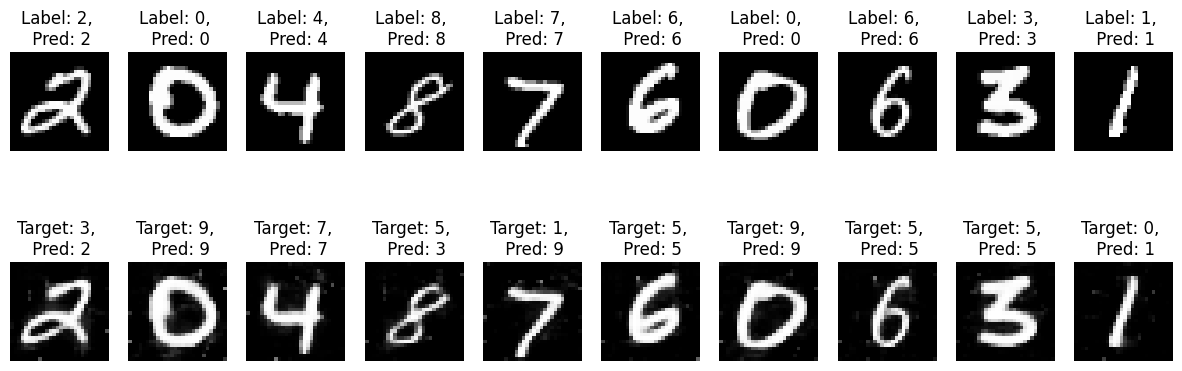

In [70]:
import matplotlib.pyplot as plt

# Function to evaluate and compare results
def evaluate_atn(original_model, atn, dataset):
    for x_batch, y_original_batch in dataset.take(1):  # Take one batch (two elements per batch in the dataset)
        # Generate transformed images
        x_transformed = atn.predict(x_batch)

        # Get predictions for the original and transformed images
        y_pred_original = tf.argmax(original_model.predict(x_batch), axis=1)
        y_pred_transformed = tf.argmax(original_model.predict(x_transformed), axis=1)

        # Get true labels
        y_true = tf.argmax(y_original_batch, axis=1)

        # Print results for comparison
        print("True Labels:", y_true.numpy())
        print("Original Predictions:", y_pred_original.numpy())
        print("Transformed Predictions:", y_pred_transformed.numpy())

        # Display images
        display_images(x_batch, x_transformed, y_true, y_pred_original, y_pred_transformed, original_model.predict(x_batch))
        break  # Only evaluate one batch for now

# Function to display images
def display_images(original_images, transformed_images, y_true, y_pred_original, y_pred_transformed, original_pred):
    num_images = min(10, len(original_images))  # Display up to 10 images
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(tf.squeeze(original_images[i]), cmap='gray')  # Remove channel for grayscale display
        plt.title(f"Label: {y_true[i].numpy()}, \n Pred: {y_pred_original[i].numpy()}")
        plt.axis('off')

        # Transformed image
        second_highest_target = get_second_highest_target(original_pred[i: i + 1])[0]  # Compute target dynamically
        second_highest_class = tf.argmax(second_highest_target).numpy()

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(tf.squeeze(transformed_images[i]), cmap='gray')
        plt.title(f"Target: {second_highest_class}, \n Pred: {y_pred_transformed[i].numpy()}")
        plt.axis('off')

    plt.show()


# Evaluate the ATN on the test dataset
evaluate_atn(original_model, atn, mnist_test_atn)


In [50]:
# Function to calculate accuracy
def calculate_accuracy(model, dataset, atn=None):
    correct = 0
    total = 0

    for x_batch, y_original_batch in dataset:  # Only unpack two elements
        if atn:
            # Transform images using ATN
            x_batch = atn.predict(x_batch, verbose=0)  # Suppress verbose output
        # Get predictions from the model
        y_pred = tf.argmax(model.predict(x_batch, verbose=0), axis=1)
        y_true = tf.argmax(y_original_batch, axis=1)  # True labels
        # Count correct predictions
        correct += tf.reduce_sum(tf.cast(y_pred == y_true, tf.float32)).numpy()
        total += x_batch.shape[0]  # Batch size
    
    return correct / total  # Calculate accuracy


# Original accuracy
original_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=None)
print(f"Accuracy on original images: {original_accuracy:.4f}")

# Transformed accuracy
transformed_accuracy = calculate_accuracy(original_model, mnist_test_atn, atn=atn)
print(f"Accuracy on transformed images: {transformed_accuracy:.4f}")


Accuracy on original images: 0.9842
Accuracy on transformed images: 0.8166
